# Detrending and de-seasoning data

In [1]:
# Load necessary modules
import intake
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram
import warnings
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(threads_per_worker = 1)

In [3]:
catalog = intake.cat.access_nri
ylength=580

In [4]:
#in this definition, no frequency can be used only for static data
def importer(experiment,catalog,variable, frequency = 'fx',start_time=0,end_time=0):
    warnings.filterwarnings('ignore')
    if experiment== "panant-01-zstar-ACCESSyr2":
        var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    else: 
        #other resolutions have the same variable with z_l and z_l_sub z dim in different times.
        # I will filter to the time I want knowing th their specificities
        #IOW this fix works just for the models and variables used in this notebook
        if variable=='uo' or variable=='vo':
            var = catalog[experiment].search(variable=variable, frequency = frequency)
            keysnames = var.keys() ; search_term = "z_l_sub01"
            matches = [s for s in keysnames if search_term in s]
            var = catalog[experiment].search(variable=variable, frequency = frequency,file_id = matches).to_dask(xarray_open_kwargs={'decode_timedelta':True})
        else:
            var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    
    if start_time!=0:
        time_slice='slice(start_time,end_time)'
        return eval("var." + variable + ".sel(time=" + time_slice + ")")
    elif start_time ==0:
        return eval("var." + variable)

In [5]:
#importing CSHT along for reference
#lighter CSHT matrix to make easier to find TS along isobath
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_along = CSHT_along.isel(time=0).drop('time')
#importing monthly potrho0 along contour
pot_rho0_along_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')
#importing 3 degrees binned u_along for reference too
#importing the daily ualong in z coords, 3deg binned 
u_along_binned_z = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z_3deg/along_slope/*')

In [6]:
#area
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
area = importer(iaf_cycle3,catalog,'area_t').isel(yt_ocean=slice(0,ylength))
area_transect = area.sel(xt_ocean = CSHT_along.lon_along_contour,yt_ocean=CSHT_along.lat_along_contour,method='nearest')
area_transect.load()
print('Loaded area along the isobath')

Loaded area along the isobath


In [7]:
# #first, creating the Z mask so we make sure we get the right sigmas in the right locations
CSHTZC_z = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

In [8]:
#improting masks
# Daily age mask
age_mask_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/*.nc')
# monthly water mass mask 
age_mask_monthly = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')

In [9]:
#importing CSHT in density bins
CSHT_along_10deg = xr.open_mfdataset('/g/data/e14/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc',\
                               chunks = {'time' : 100,'lon_bins':12})

In [10]:
age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')

In [11]:
daily_age_mask = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/*.nc')

In [12]:
asc_speed_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_sigma_daily_10deg/OM2_01_iaf_cycle3/*.nc')

In [13]:
Volume_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/volume_daily_10deg/OM2_01_iaf_cycle3/VOL*.nc')

In [14]:
u_daily_along_CDW = ((asc_speed_daily.U*daily_age_mask.CDW_mask*Volume_daily.Volume).sum('potrho0')/(daily_age_mask.CDW_mask*Volume_daily.Volume).sum('potrho0')).compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [15]:
#annual mean CSHT from CDW
CSHT_CDW = (CSHT_along_10deg.CSHT_ZC_lon_binned * age_mask_daily.CDW_mask).sum('potrho0').compute()


## Estimating the required $n$ for correlations

Climate time-series have a large auto-correlation, due to syncronous changes in variables driven by the same forcing (e.g., seasonal radiative varaibility). That means they will tend to have high correlations naturally, due to the syncronicity of the variaiblity. But that doesn't mean othe predictive variable is actually explaining the predicted one. To solve this problem we need to do two things: (1) have a high enough number of sambles $n$ to increase the robustness of correlations, and (2) remove seasonality and intrinsic trends in the data that baises correlations to larger values.

As a first sanity check step, lets estimate the time sample size we would need o properly estimate correlations in our timeseries, for a single longitude bin. That would be done by calcualting:

$$
N_{def} = N \left( \frac{1 - r_{u} r_{HT}}{1 + r_{u} r_{HT}} \right)
$$

where $N$ is the current time sample numbers, $r_{u}$ is the lag 1 auto-correlation for the ASC timeseries, and $r_{HT}$ is the lag 1 auto-correlation for the Cross-slope heat transport.

Let's calculate that

In [16]:
N = float(CSHT_CDW.time.count())

# Setting timeseries for proper lag 1 auto-correlation of U
U0 = u_daily_along_CDW.isel(time=slice(0,-1)).copy()
U1 = u_daily_along_CDW.isel(time=slice(1,22280)).copy()
U1['time'] = U0.time #correcting timefor proper lag 1 correlation
# calculating ASC lag 1 auto-correlation
r_u = xr.corr(U0,U1,dim = 'time').compute()


# Setting timeseries for proper lag 1 auto-correlation of CSHT
HT0 = CSHT_CDW.isel(time=slice(0,-1)).copy()
HT1 = CSHT_CDW.isel(time=slice(1,22280)).copy()
HT1['time'] = HT0.time
# calculating ASC lag 1 auto-correlation of CSHT
r_HT = xr.corr(HT0,HT1,dim = 'time').compute()
r_u.max(),r_HT.max()

(<xarray.DataArray ()> Size: 8B
 array(0.98663017),
 <xarray.DataArray ()> Size: 8B
 array(0.81779177))

In [17]:
## calculating Ndeff
NDeff = N * ( (1 - (r_u*r_HT)) / (1 + (r_u*r_HT)) )

In [18]:
#Extarcting the N that we need (minimum N, maximum across bins)
print( 'We need n= ' + str(int(NDeff.max())) + ' samples in time to do a correlation')

We need n= 20305 samples in time to do a correlation


Which means that 65 year instances or 365 days are not enough. So we need to do a detrending to allow us to use the whole timeseries of daily data

## Detrending data

In [19]:
from scipy import signal

In [20]:
def linear_detrend(da):
    da_detrended = xr.apply_ufunc(
        signal.detrend,                   # function to apply
        da,                               # data
        input_core_dims=[['time']],       # core dimension to operate along
        output_core_dims=[['time']],
        kwargs={'axis': -1, 'type': 'linear'},  # linear detrend
        dask='parallelized',              # allows use with dask-backed arrays
        output_dtypes=[da.dtype]          # preserve dtype
    ) 
    damean = da.mean('time')
    da_detrended = da_detrended+damean
    return da_detrended

detrending data

In [21]:
u_daily_along_CDW_detrended = linear_detrend(u_daily_along_CDW.interpolate_na(dim='time', method='linear'))
#u_daily_along_CDW_detrended = u_daily_along_CDW_detrended.where(u_daily_along_CDW_detrended<=0.035).where(u_daily_along_CDW_detrended>=-0.045).interpolate_na(dim='time', method='linear')
#optional below of removing the mean
#u_daily_along_CDW_detrended = u_daily_along_CDW_detrended - u_daily_along_CDW_detrended.mean('time')

#CSHT
CSHT_CDW_detrended = linear_detrend(CSHT_CDW)
#optional below of removing the mean
#CSHT_CDW_detrended = CSHT_CDW_detrended - CSHT_CDW_detrended.mean('time')

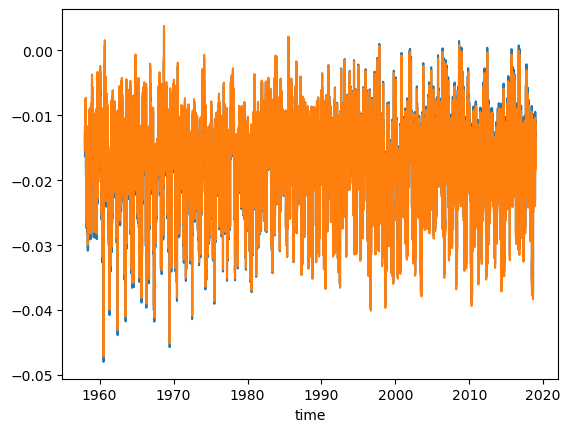

In [22]:
u_daily_along_CDW.mean('lon_bins').plot()
u_daily_along_CDW_detrended.mean('lon_bins').plot()

In [23]:
# how much was the trend in each series?
U_trend = (u_daily_along_CDW - u_daily_along_CDW_detrended).mean('lon_bins').mean('time')*365 #(m/s)/year
CSHT_trend = (CSHT_CDW - CSHT_CDW_detrended).mean('time').mean('lon_bins')*365 #(W)/year
U_trend,CSHT_trend

(<xarray.DataArray ()> Size: 8B
 array(9.22467125e-05),
 <xarray.DataArray ()> Size: 8B
 array(0.13947828))

## Creating annual and seasonal timeseries

In order to preserve the high $n$ of the daily timeseries, we will use a moving average of 365 days (a year) in the daily data. That will remove seasonal ariability and create our series for the interannual correlations

In [24]:
u_daily_along_CDW_detrended_annual = u_daily_along_CDW_detrended.rolling(time=365,min_periods=1,center=True).mean()
u_daily_along_CDW_detrended_annual_mean = u_daily_along_CDW_detrended_annual.mean('time') # to be added to restore their mean state
CSHT_CDW_detrended_annual = CSHT_CDW_detrended.rolling(time=365,min_periods=1).mean()
CSHT_CDW_detrended_annual_mean = CSHT_CDW_detrended_annual.mean('time')# to be added to restore their mean state

Calculating the seasonal variability timeseries

In [25]:
#I will try to get the seasonal timeseries by doing a 5 days filter on the detrended, deannualled series
u_daily_along_CDW_detrended_seasonal = (u_daily_along_CDW_detrended - u_daily_along_CDW_detrended_annual).rolling(time=30,min_periods=1,center=True).mean()
u_daily_along_CDW_detrended_seasonal = u_daily_along_CDW_detrended_seasonal + u_daily_along_CDW_detrended.mean('time')
CSHT_CDW_detrended_seasonal = (CSHT_CDW_detrended - CSHT_CDW_detrended_annual).rolling(time=30,min_periods=1,center=True).mean()
CSHT_CDW_detrended_seasonal = CSHT_CDW_detrended_seasonal + CSHT_CDW_detrended.mean('time')

In [26]:
#DAily timeseries
u_daily_along_CDW_detrended_daily = (u_daily_along_CDW_detrended - u_daily_along_CDW_detrended_annual - u_daily_along_CDW_detrended_seasonal)
u_daily_along_CDW_detrended_daily = u_daily_along_CDW_detrended_daily + 2*u_daily_along_CDW_detrended.mean('time') #added twice because we removed the mean twice
CSHT_CDW_detrended_daily = (CSHT_CDW_detrended - CSHT_CDW_detrended_annual - CSHT_CDW_detrended_seasonal)
CSHT_CDW_detrended_daily =CSHT_CDW_detrended_daily + 2*CSHT_CDW_detrended.mean('time')#added twice because we removed the mean twice

Sanity check for ASC speed

(-4400, -1000)

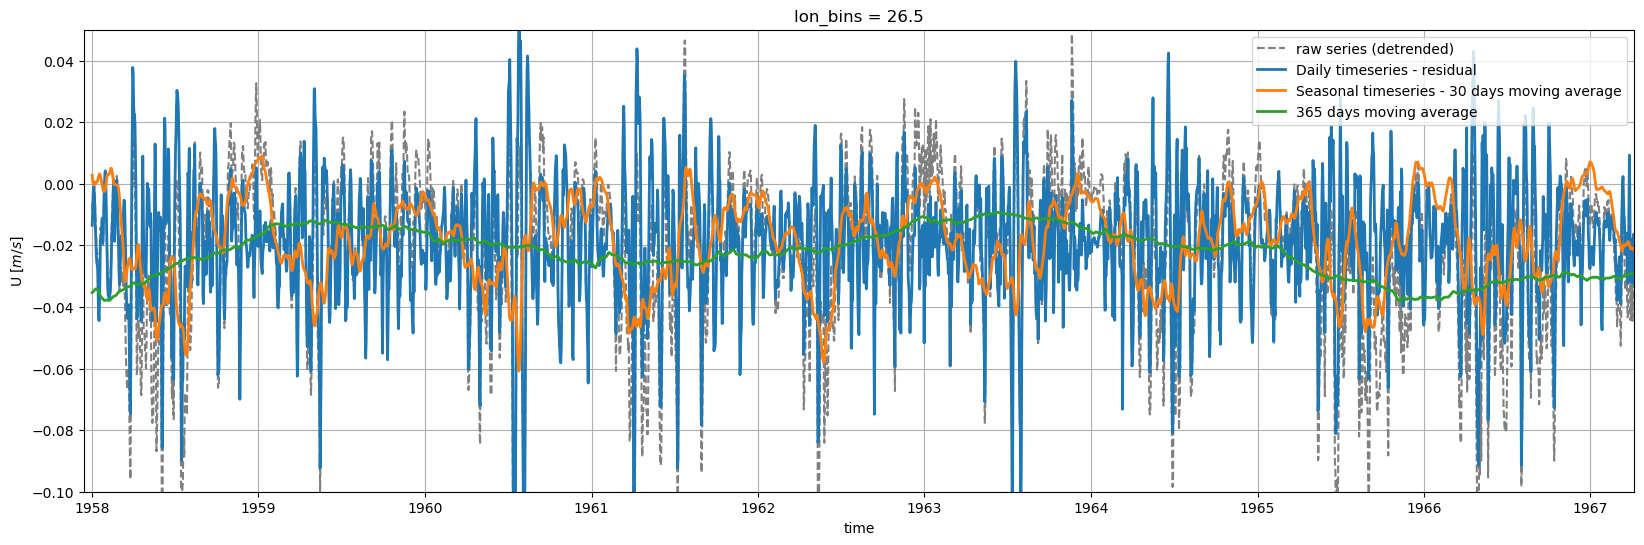

In [27]:
plt.figure(figsize=(20,6))
u_daily_along_CDW_detrended.isel(lon_bins=30).plot(label = 'raw series (detrended)',color='grey',linestyle='--')
u_daily_along_CDW_detrended_daily.isel(lon_bins=30).plot(linewidth=2,label = 'Daily timeseries - residual',color='tab:blue')
u_daily_along_CDW_detrended_seasonal.isel(lon_bins=30).plot(linewidth=2,label = 'Seasonal timeseries - 30 days moving average',color='tab:orange')
u_daily_along_CDW_detrended_annual.isel(lon_bins=30).plot(linewidth=2,label = '365 days moving average',color='tab:green')
plt.ylim(-0.1,0.05)
plt.grid()
plt.legend()
plt.ylabel(r'U [$m/s$]')
plt.xlim(-4400,-1000)#-4400,18000
# plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Series_ASC_raw.png',dpi=300)

Sanity check for the CSHT

(-4400, -1000)

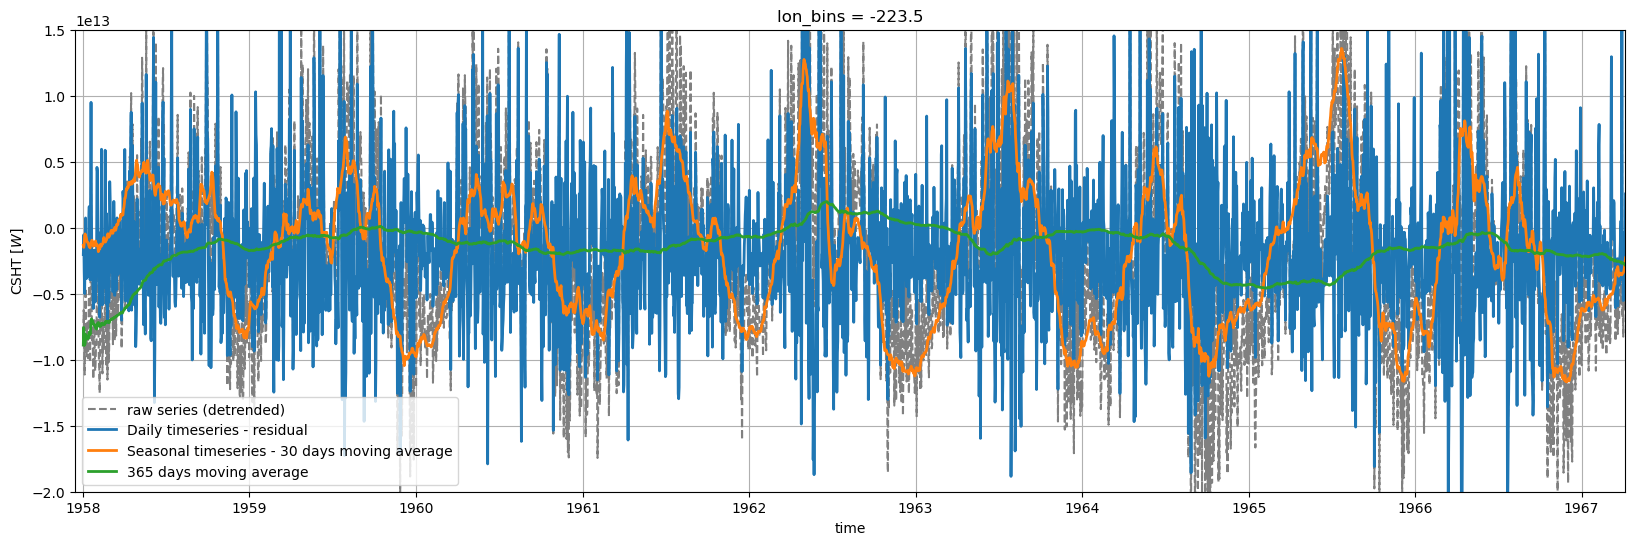

In [28]:
plt.figure(figsize=(20,6))
CSHT_CDW_detrended.isel(lon_bins=5).plot(label = 'raw series (detrended)',color='grey',linestyle='--')
CSHT_CDW_detrended_daily.isel(lon_bins=5).plot(linewidth=2,label = 'Daily timeseries - residual',color='tab:blue')
CSHT_CDW_detrended_seasonal.isel(lon_bins=5).plot(linewidth=2,label = 'Seasonal timeseries - 30 days moving average',color='tab:orange')
CSHT_CDW_detrended_annual.isel(lon_bins=5).plot(linewidth=2,label = '365 days moving average',color='tab:green')
plt.ylim(-2e13,1.5e13)
plt.grid()
plt.legend()
plt.ylabel(r'CSHT [$W$]')
plt.xlim(-4400,-1000)#-4400,18000
# plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Series_CSHT_raw_annual_seasonal_daily.png',dpi=300)

New ndeffs for each series

In [29]:
#annual
N = float(CSHT_CDW_detrended_annual.time.count())

# Setting timeseries for proper lag 1 auto-correlation of U
U0 = u_daily_along_CDW_detrended_annual.isel(time=slice(0,-1)).copy()
U1 = u_daily_along_CDW_detrended_annual.isel(time=slice(1,22280)).copy()
U1['time'] = U0.time #correcting timefor proper lag 1 correlation
# calculating ASC lag 1 auto-correlation
r_u = xr.corr(U0,U1,dim = 'time').compute()


# Setting timeseries for proper lag 1 auto-correlation of CSHT
HT0 = CSHT_CDW_detrended_annual.isel(time=slice(0,-1)).copy()
HT1 = CSHT_CDW_detrended_annual.isel(time=slice(1,22280)).copy()
HT1['time'] = HT0.time
# calculating ASC lag 1 auto-correlation of CSHT
r_HT = xr.corr(HT0,HT1,dim = 'time').compute()
## calculating Ndeff
NDeff_annual = N * ( (1 - (r_u*r_HT)) / (1 + (r_u*r_HT)) )
NDeff_annual.max()
r_u.max().values,r_HT.max().values
print('NDeff annual now is ' + str(np.round(NDeff_annual.max().values)))


NDeff annual now is 48.0


In [30]:
#seasonal
N = float(CSHT_CDW_detrended_seasonal.time.count())

# Setting timeseries for proper lag 1 auto-correlation of U
U0 = u_daily_along_CDW_detrended_seasonal.isel(time=slice(0,-1)).copy()
U1 = u_daily_along_CDW_detrended_seasonal.isel(time=slice(1,22280)).copy()
U1['time'] = U0.time #correcting timefor proper lag 1 correlation
# calculating ASC lag 1 auto-correlation
r_u = xr.corr(U0,U1,dim = 'time').compute()


# Setting timeseries for proper lag 1 auto-correlation of CSHT
HT0 = CSHT_CDW_detrended_seasonal.isel(time=slice(0,-1)).copy()
HT1 = CSHT_CDW_detrended_seasonal.isel(time=slice(1,22280)).copy()
HT1['time'] = HT0.time
# calculating ASC lag 1 auto-correlation of CSHT
r_HT = xr.corr(HT0,HT1,dim = 'time').compute()
## calculating Ndeff
NDeff_seasonal = N * ( (1 - (r_u*r_HT)) / (1 + (r_u*r_HT)) )
r_u.max().values,r_HT.max().values
print('NDeff seasonal now is ' + str(np.round(NDeff_seasonal.max().values)))

NDeff seasonal now is 247.0


In [31]:
#daily
N = float(CSHT_CDW_detrended_daily.time.count())

# Setting timeseries for proper lag 1 auto-correlation of U
U0 = u_daily_along_CDW_detrended_daily.isel(time=slice(0,-1)).copy()
U1 = u_daily_along_CDW_detrended_daily.isel(time=slice(1,22280)).copy()
U1['time'] = U0.time #correcting timefor proper lag 1 correlation
# calculating ASC lag 1 auto-correlation
r_u = xr.corr(U0,U1,dim = 'time').compute()


# Setting timeseries for proper lag 1 auto-correlation of CSHT
HT0 = CSHT_CDW_detrended_daily.isel(time=slice(0,-1)).copy()
HT1 = CSHT_CDW_detrended_daily.isel(time=slice(1,22280)).copy()
HT1['time'] = HT0.time
# calculating ASC lag 1 auto-correlation of CSHT
r_HT = xr.corr(HT0,HT1,dim = 'time').compute()
## calculating Ndeff
NDeff_daily = N * ( (1 - (r_u*r_HT)) / (1 + (r_u*r_HT)) )
print('NDeff daily now is ' + str(np.round(NDeff_daily.max().values)))

NDeff daily now is 22841.0


We wouldn't be able to resolve the daily cycle

## Comparying filtered series and annual means series

In [32]:
ASC_annual_old = u_daily_along_CDW.resample(time='1Y').mean()
ASC_seasonal_old = u_daily_along_CDW.groupby('time.dayofyear').mean().isel(dayofyear=slice(0,365))
# #CSHT
CSHT_CDW_old = CSHT_CDW.resample(time='1Y').mean()
CSHT_seasonal_old = CSHT_CDW.groupby('time.dayofyear').mean().isel(dayofyear=slice(0,365))

Calculating N's for the old timeseries

In [33]:
#old annual
N = float(ASC_annual_old.time.count())

# Setting timeseries for proper lag 1 auto-correlation of U
U0 = ASC_annual_old.isel(time=slice(0,-1)).copy()
U1 = ASC_annual_old.isel(time=slice(1,61)).copy()
U1['time'] = U0.time #correcting timefor proper lag 1 correlation
# calculating ASC lag 1 auto-correlation
r_u = xr.corr(U0,U1,dim = 'time').compute()


# Setting timeseries for proper lag 1 auto-correlation of CSHT
HT0 = CSHT_CDW_old.isel(time=slice(0,-1)).copy()
HT1 = CSHT_CDW_old.isel(time=slice(1,61)).copy()
HT1['time'] = HT0.time
# calculating ASC lag 1 auto-correlation of CSHT
r_HT = xr.corr(HT0,HT1,dim = 'time').compute()
## calculating Ndeff
NDeff_annual_old = N * ( (1 - (r_u*r_HT)) / (1 + (r_u*r_HT)) )
NDeff_annual_old.max()
print('NDeff in the older version of annual series is ' + str(np.round(NDeff_annual_old.max().values)))

NDeff in the older version of annual series is 63.0


In [41]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
longitude_inds = np.array([5,36-15, 14, 3,10,17,36-12,36-10, 36-1,1])
regions_abridged = ['Mertz','WAP', 'Getz', 'Totten',\
           'Glomar', 'Amundsen', 'Filchner', \
           'Riiser-Larsen', 'Amery', 'Denman']

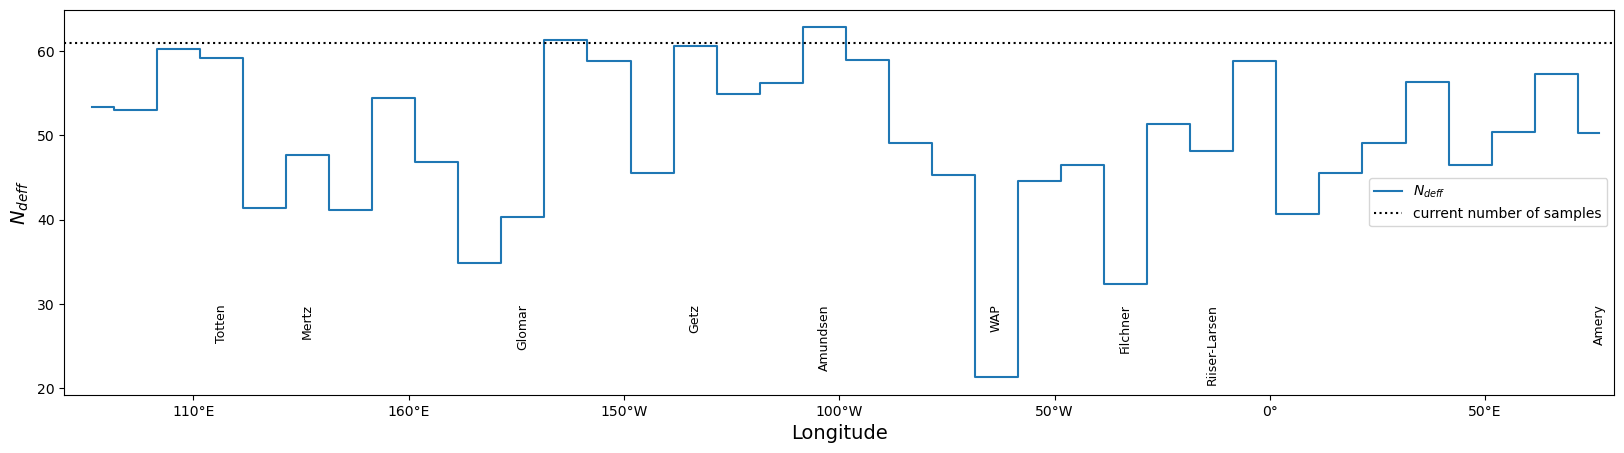

In [56]:
fig = plt.figure(figsize=(20,5))

ax0 = fig.add_subplot(1,1,1)
plt.step(NDeff_annual_old.lon_bins,NDeff_annual_old, where='mid',label = r'$N_{deff}$')
plt.plot([-280,80],[61,61], color='k',linestyle=':',label = r'current number of samples')
plt.title('')
plt.ylabel(r'$N_{deff}$',fontsize = 14)
for i in range(9):
    plt.text(NDeff_annual_old.lon_bins[longitude_inds[i]], 30, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.xlim(-280,80)
#plt.ylim(-.25,.75)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude',fontsize = 14)
plt.legend()

In [35]:
#old daily
N = float(ASC_seasonal_old.dayofyear.count())

# Setting timeseries for proper lag 1 auto-correlation of U
U0 = ASC_seasonal_old.isel(dayofyear=slice(0,-1)).copy()
U1 = ASC_seasonal_old.isel(dayofyear=slice(1,365)).copy()
U1['dayofyear'] = U0.dayofyear #correcting timefor proper lag 1 correlation
# calculating ASC lag 1 auto-correlation
r_u = xr.corr(U0,U1,dim = 'dayofyear').compute()


# Setting timeseries for proper lag 1 auto-correlation of CSHT
HT0 = CSHT_seasonal_old.isel(dayofyear=slice(0,-1)).copy()
HT1 = CSHT_seasonal_old.isel(dayofyear=slice(1,365)).copy()
HT1['dayofyear'] = HT0.dayofyear
# calculating ASC lag 1 auto-correlation of CSHT
r_HT = xr.corr(HT0,HT1,dim = 'dayofyear').compute()
## calculating Ndeff
NDeff_seasonal_old = N * ( (1 - (r_u*r_HT)) / (1 + (r_u*r_HT)) )
NDeff_seasonal_old.max()
print('NDeff in the older version of seasonal series is ' + str(np.round(NDeff_seasonal_old.max().values)))

NDeff in the older version of seasonal series is 199.0


In [36]:
NDeff_seasonal_old

<xarray.DataArray (lon_bins: 36)> Size: 288B
array([121.3222184 ,  43.28168346,  81.77601349,  81.26533642,
        23.5616009 ,   6.15874762,  19.05937393, 198.66086785,
        31.66711346,  22.11305385,  35.06338226,  28.37830083,
        37.78813658,  76.19227754,  64.54215361,  98.81454257,
        58.15335638,  87.60450661,  70.24418431,  39.25070874,
        42.94231214,  23.65483576,  38.77109599,   7.60724272,
        22.16808405,  50.83920091,  26.2537468 ,  72.41399365,
       130.71772043,  85.32154059,  28.73501778,  31.48937658,
        70.01598985,  21.74912731,  13.15077894,  36.90817948])
Coordinates:
  * lon_bins  (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5

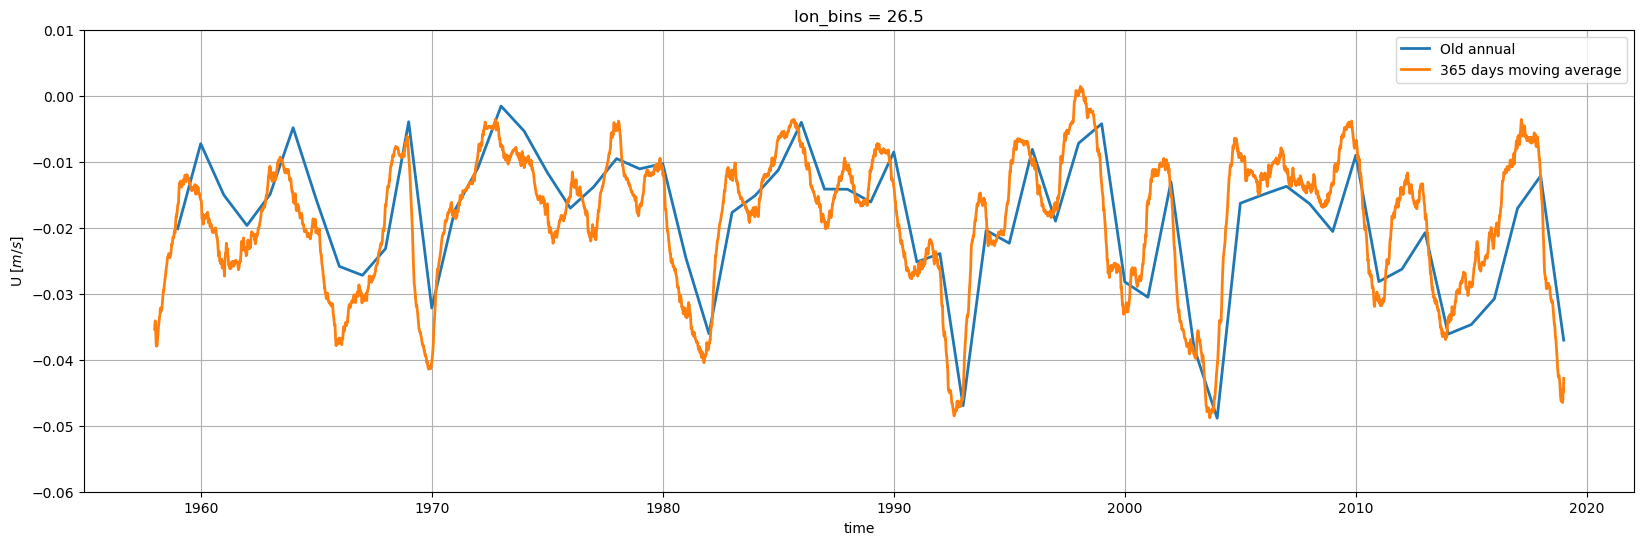

In [83]:
plt.figure(figsize=(20,6))
ASC_annual_old.isel(lon_bins=30).plot(linewidth=2,label = 'Old annual')
u_daily_along_CDW_detrended_annual.isel(lon_bins=30).plot(linewidth=2,label = '365 days moving average')
plt.ylim(-0.06,0.01)
plt.grid()
plt.legend()
plt.ylabel(r'U [$m/s$]')
plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Series_ASC_annual_2types.png',dpi=300)

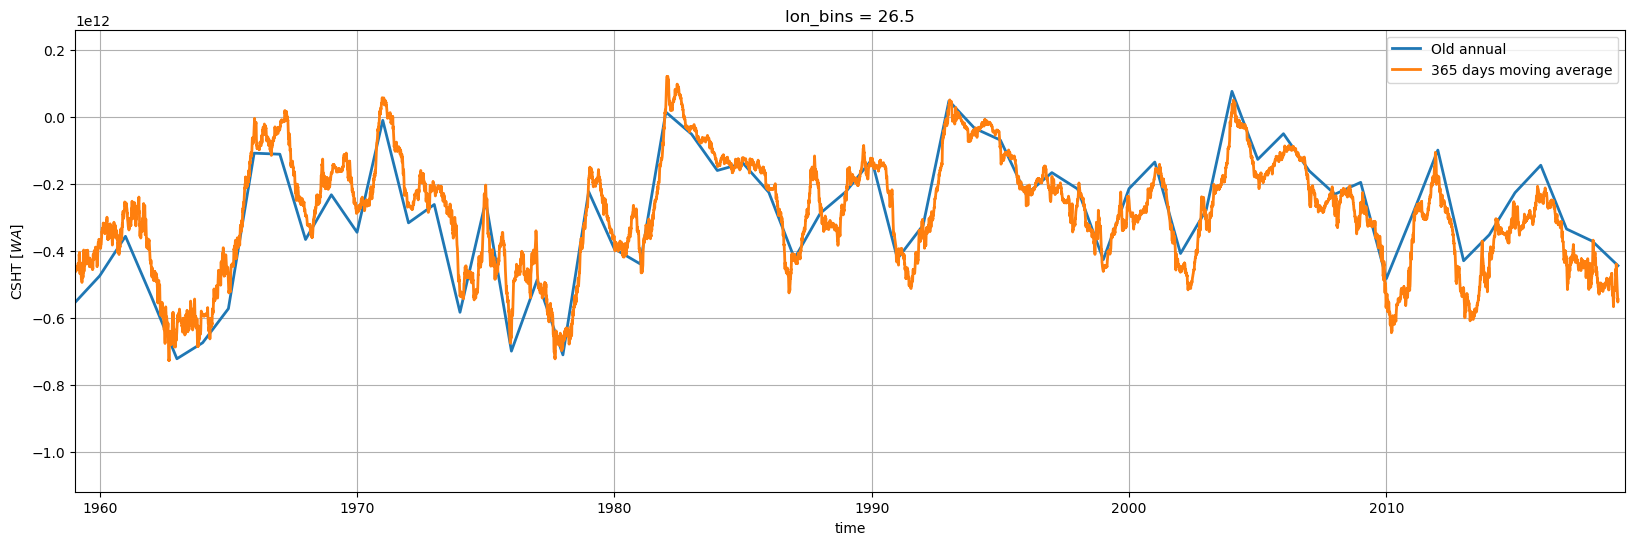

In [102]:
plt.figure(figsize=(20,6))
CSHT_CDW_old.isel(lon_bins=30).plot(linewidth=2,label = 'Old annual')
CSHT_CDW_detrended_annual.isel(lon_bins=30).plot(linewidth=2,label = '365 days moving average')
#plt.ylim(-0.06,0.01)
plt.grid()
plt.legend()
plt.ylabel(r'CSHT [$WA$]')
plt.xlim(-4000,18000)#-4400,18000
plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Series_CSHT_annual_2types.png',dpi=300)

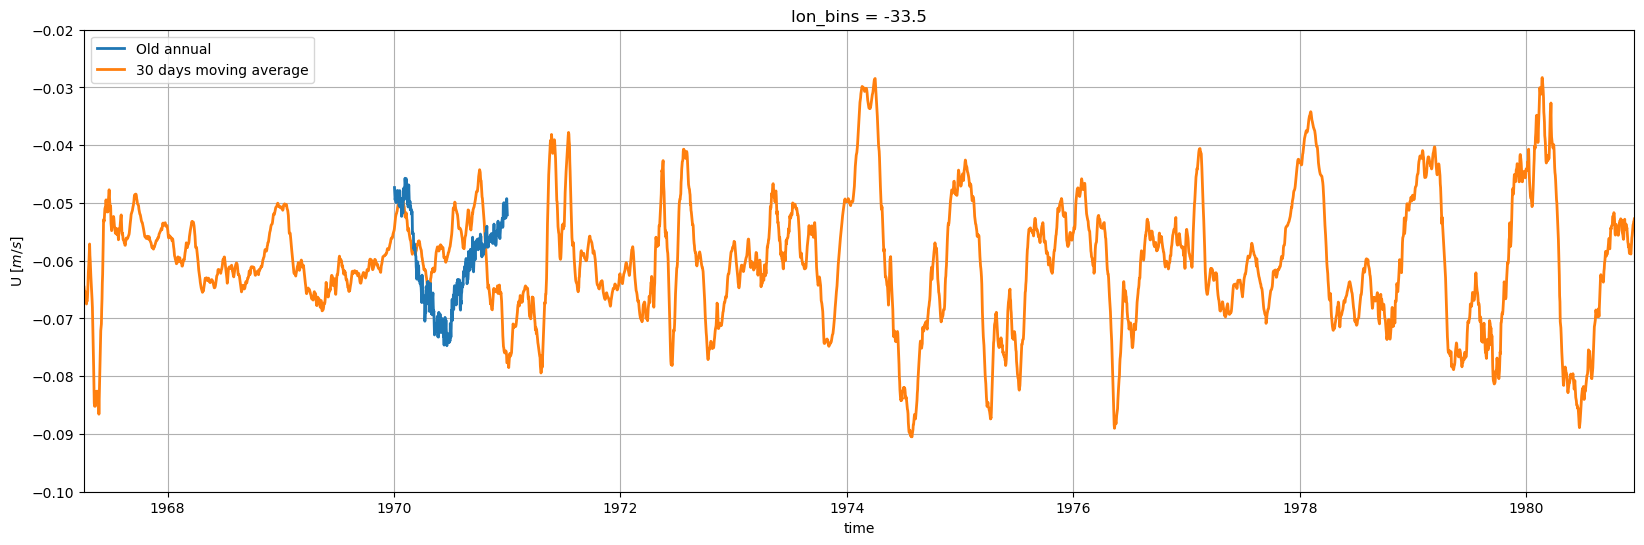

In [130]:
plt.figure(figsize=(20,6))
ASC_seasonal_old.isel(lon_bins=36-12).plot(linewidth=2,label = 'Old annual',zorder=3)
u_daily_along_CDW_detrended_seasonal.isel(lon_bins=36-12).plot(linewidth=2,label = '30 days moving average')
plt.ylim(-0.1,-0.02)
plt.grid()
plt.legend()
plt.ylabel(r'U [$m/s$]')
plt.xlim(-1000,4000)
plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Series_ASC_seasonal_2types_filchner.png',dpi=300)

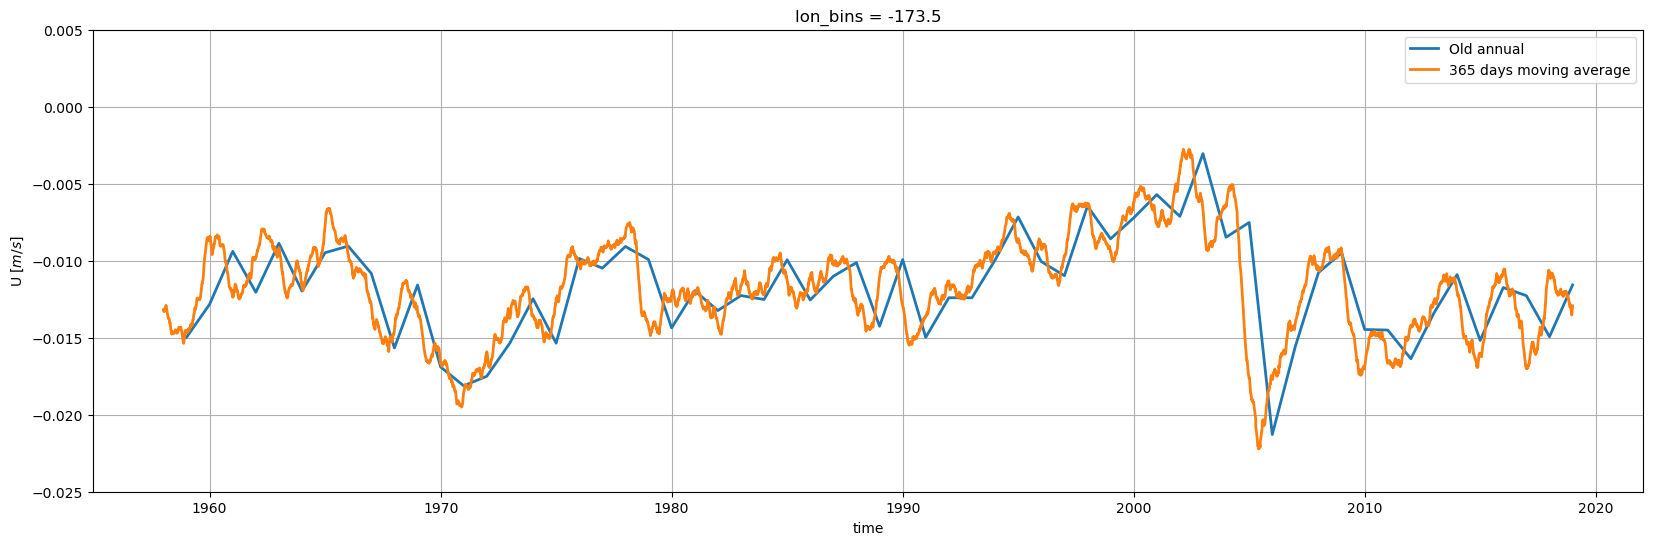

In [112]:
#for globar
plt.figure(figsize=(20,6))
ASC_annual_old.isel(lon_bins=10).plot(linewidth=2,label = 'Old annual')
u_daily_along_CDW_detrended_annual.isel(lon_bins=10).plot(linewidth=2,label = '365 days moving average')
plt.ylim(-0.025,0.005)
plt.grid()
plt.legend()
plt.ylabel(r'U [$m/s$]')
plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Series_ASC_annual_2types_glomar.png',dpi=300)

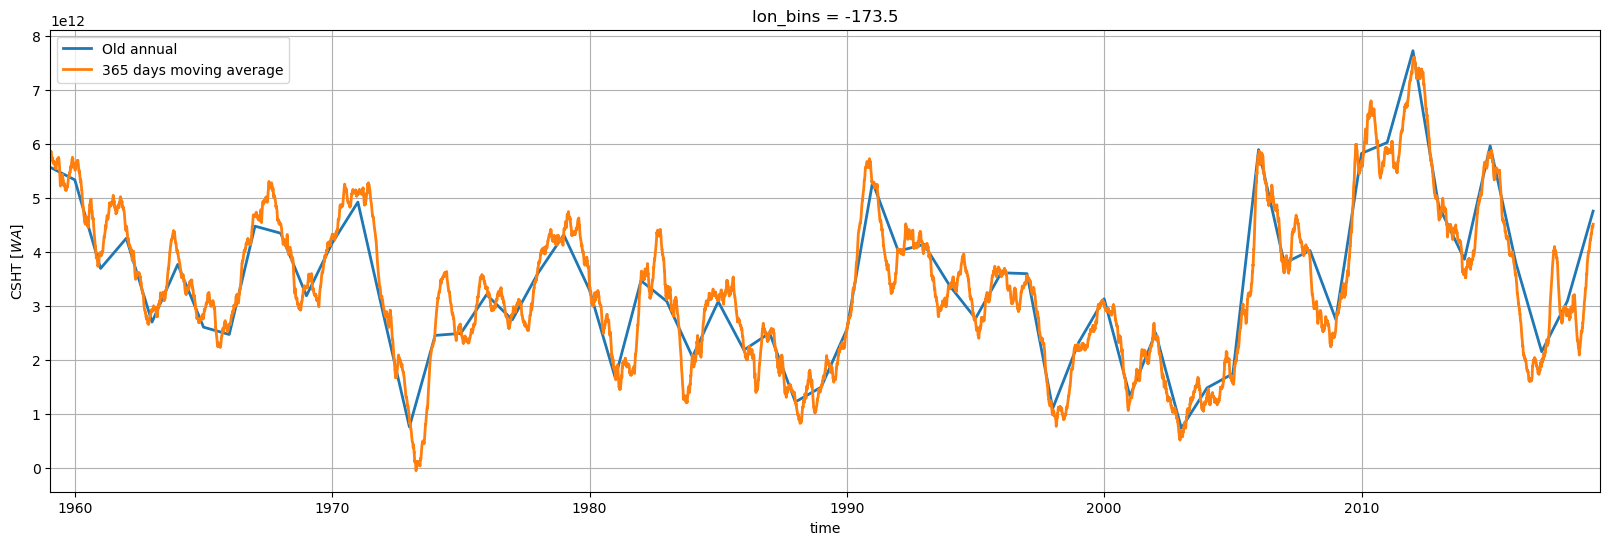

In [113]:
plt.figure(figsize=(20,6))
CSHT_CDW_old.isel(lon_bins=10).plot(linewidth=2,label = 'Old annual')
CSHT_CDW_detrended_annual.isel(lon_bins=10).plot(linewidth=2,label = '365 days moving average')
#plt.ylim(-0.06,0.01)
plt.grid()
plt.legend()
plt.ylabel(r'CSHT [$WA$]')
plt.xlim(-4000,18000)#-4400,18000
plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Series_CSHT_annual_2types_glomar.png',dpi=300)

## Correlations used longer filtered timeseries

In [103]:
annual_r2 = (xr.corr(u_daily_along_CDW_detrended_annual,CSHT_CDW_detrended_annual,dim = 'time')**2).compute()
seasonal_r2 = (xr.corr(u_daily_along_CDW_detrended_seasonal,CSHT_CDW_detrended_seasonal,dim = 'time')**2).compute()
daily_r2 = (xr.corr(u_daily_along_CDW_detrended_daily,CSHT_CDW_detrended_daily,dim = 'time')**2).compute()

In [104]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
longitude_inds = np.array([5,36-15, 14, 3,10,17,36-12,36-10, 36-1,1])
regions_abridged = ['Mertz','WAP', 'Getz', 'Totten',\
           'Glomar', 'Amundsen', 'Filchner', \
           'Riiser-Larsen', 'Amery', 'Denman']

calculating the correlations as we did before, for comparisson

In [105]:
#old rsquare values
r_sq_daily_10deg = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/r_sq_seasonal.nc')
r_sq_annual_10deg = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/r_sq_annual.nc')

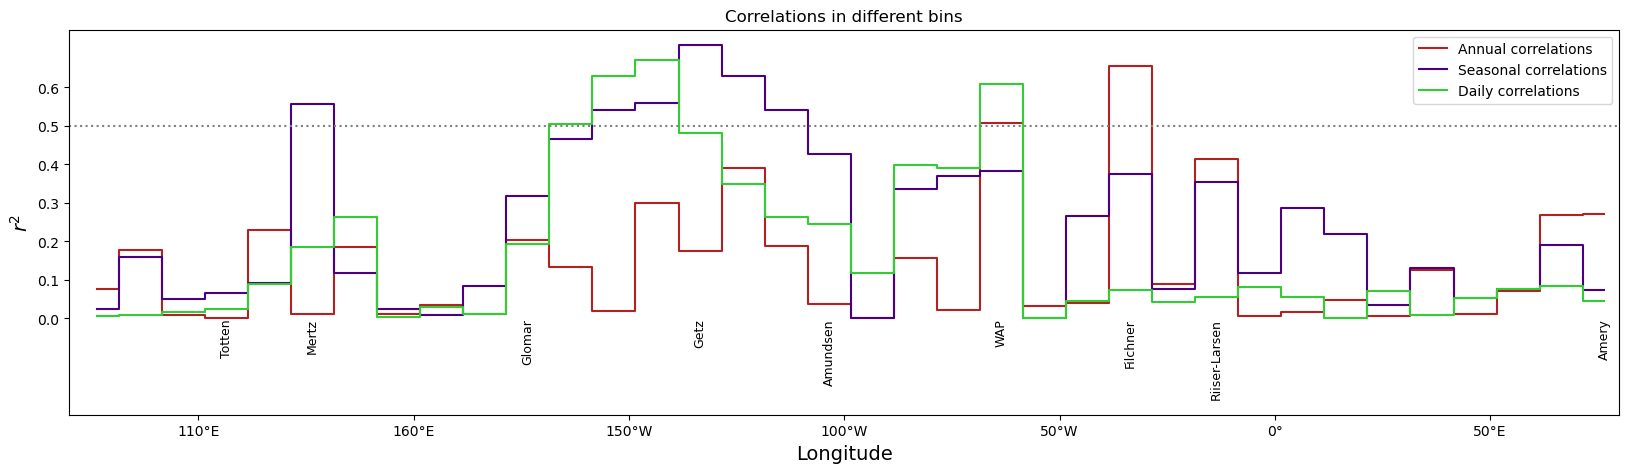

In [106]:
fig = plt.figure(figsize=(20,5))

ax0 = fig.add_subplot(1,1,1)
plt.step(annual_r2.lon_bins,annual_r2, where='mid',color='firebrick',label = 'Annual correlations')
plt.step(seasonal_r2.lon_bins,seasonal_r2, where='mid',color='indigo',label = 'Seasonal correlations')
plt.step(daily_r2.lon_bins,daily_r2, where='mid',color='limegreen',label = 'Daily correlations')
plt.plot([-280,80],[0.5,0.5],color='grey',linestyle=':')
plt.title('Correlations in different bins')
plt.ylabel(r'$r^2$',fontsize = 14)
for i in range(9):
    plt.text(annual_r2.lon_bins[longitude_inds[i]], 0, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.xlim(-280,80)
plt.ylim(-.25,.75)
plt.yticks(ticks=[0,0.1,.2,.3,.4,.5,.6])
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude',fontsize = 14)
plt.legend()


Comparisson between old and new correlations

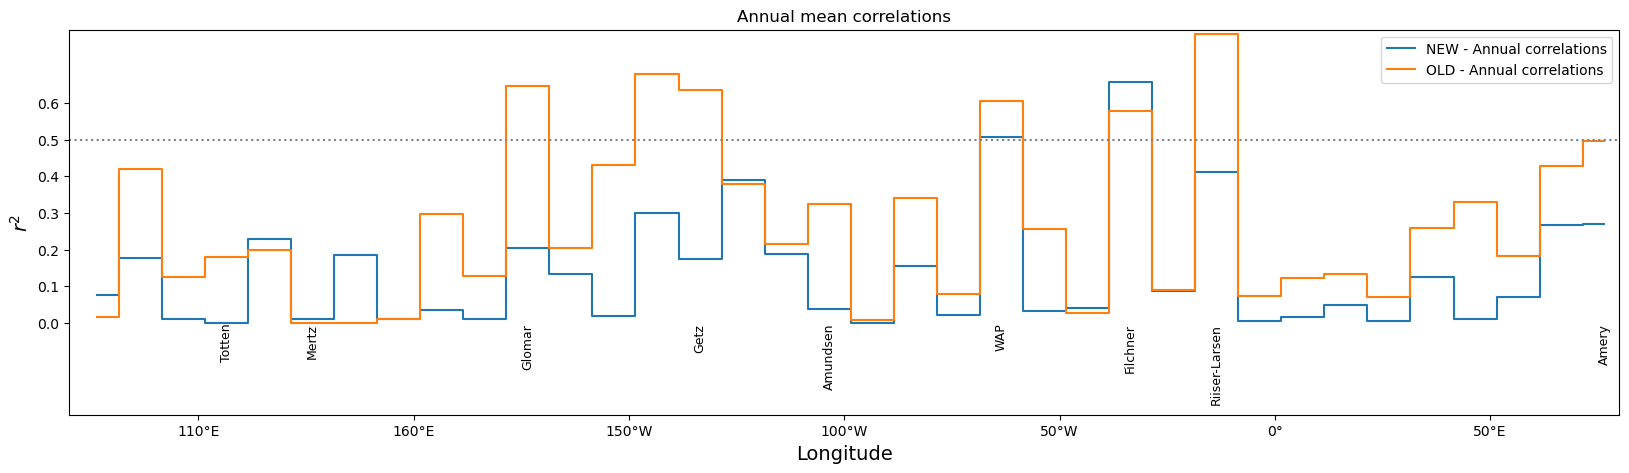

In [107]:
fig = plt.figure(figsize=(20,5))

ax0 = fig.add_subplot(1,1,1)
plt.step(annual_r2.lon_bins,annual_r2, where='mid',label = 'NEW - Annual correlations')
plt.step(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg.r_sq_annual, where='mid',label = 'OLD - Annual correlations')
plt.plot([-280,80],[0.5,0.5],color='grey',linestyle=':')
plt.title('Annual mean correlations')
plt.ylabel(r'$r^2$',fontsize = 14)
for i in range(9):
    plt.text(annual_r2.lon_bins[longitude_inds[i]], 0, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.xlim(-280,80)
plt.ylim(-.25,.8)
plt.yticks(ticks=[0,0.1,.2,.3,.4,.5,.6])
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude',fontsize = 14)
plt.legend()


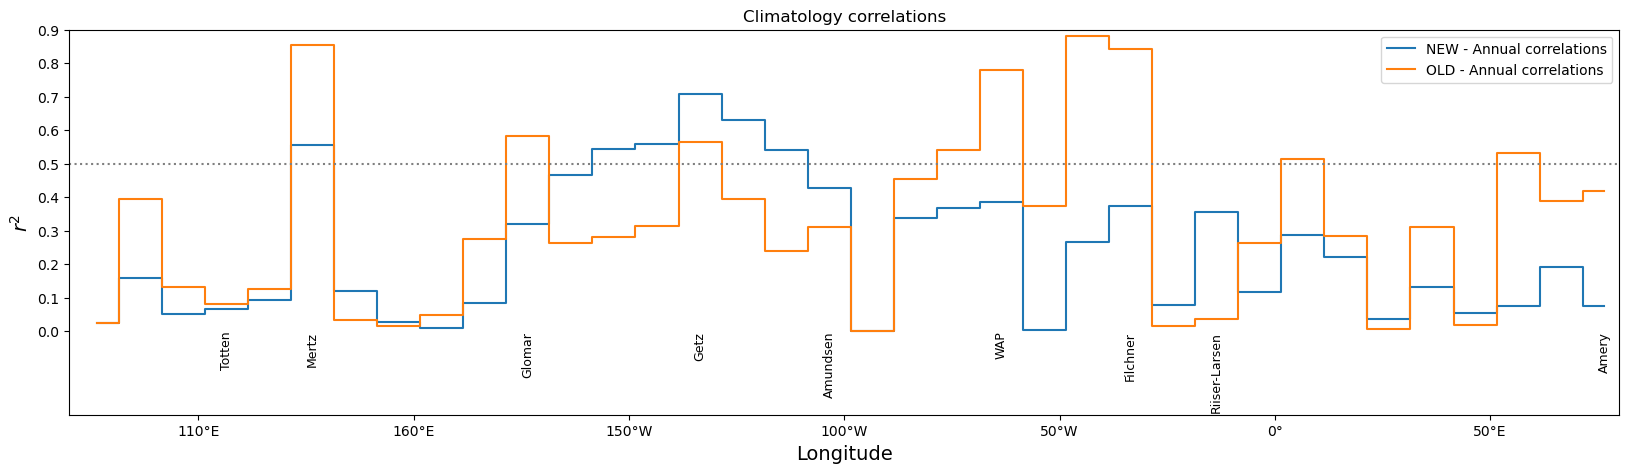

In [109]:
fig = plt.figure(figsize=(20,5))

ax0 = fig.add_subplot(1,1,1)
plt.step(seasonal_r2.lon_bins,seasonal_r2, where='mid',label = 'NEW - Annual correlations')
plt.step(r_sq_daily_10deg.lon_bins,r_sq_daily_10deg.r_sq_clim, where='mid',label = 'OLD - Annual correlations')
plt.plot([-280,80],[0.5,0.5],color='grey',linestyle=':')
#plt.plot([-280,80],[0.4,0.4],color='grey',linestyle=':')
plt.title('Climatology correlations')
plt.ylabel(r'$r^2$',fontsize = 14)
for i in range(9):
    plt.text(annual_r2.lon_bins[longitude_inds[i]], 0, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.xlim(-280,80)
plt.ylim(-.25,.9)
plt.yticks(ticks=[0,0.1,.2,.3,.4,.5,.6,.7,.8,.9])
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude',fontsize = 14)
plt.legend()


# Testing the hypothesis of continuity

Even tho DSW doesnt overflow everywhere in teh shelf, we should have nortward flowing waters in any level to compensate for CDW flowing in. Let's explore the hypothesis that that continuity in the mass exchange is what is ruling the heat transport physically here. Physically, that would mean that iN DSW sites, outflow of DSW invites CDW to the shelf, but in other sites, ourflow of not-too-dense waters, or even ekman-driven outflow of surface waters rules the relationship

In [110]:
#annual mean CSHT from different water masses
CSHT_AASW0 = (CSHT_along_10deg.CSHT_ZC_lon_binned * age_mask_daily.AASW_mask)
CSHT_AASW = (CSHT_along_10deg.CSHT_ZC_lon_binned * age_mask_daily.AASW_mask).sum('potrho0').compute()
CSHT_AASW_pos  = CSHT_AASW0.where(CSHT_AASW0 >0).sum('potrho0').compute()
CSHT_DSW0 = (CSHT_along_10deg.CSHT_ZC_lon_binned * age_mask_daily.DSW_mask)
CSHT_DSW = (CSHT_along_10deg.CSHT_ZC_lon_binned * age_mask_daily.DSW_mask).sum('potrho0').compute()
CSHT_DSW_pos = CSHT_DSW0.where(CSHT_DSW0>0).sum('potrho0').compute()

In [111]:
#correlations with different water masses heat transport
AASW_CDW_r = xr.corr(CSHT_AASW,CSHT_CDW,dim = 'time').compute()
AASW_CDW_r2 = ((AASW_CDW_r.where(AASW_CDW_r<0)*0)-1).fillna(1) * (AASW_CDW_r**2)

DSW_CDW_r = xr.corr(CSHT_DSW,CSHT_CDW,dim = 'time').compute()
DSW_CDW_r2 = ((DSW_CDW_r.where(DSW_CDW_r<0)*0)-1).fillna(1) * (DSW_CDW_r**2)

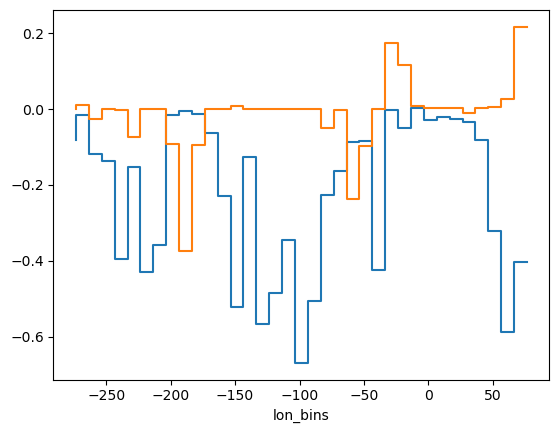

In [112]:
AASW_CDW_r2.plot.step()
DSW_CDW_r2.plot.step()

In [113]:
#correlation of CDW CSHT other transports
layerwise_CDW_r = xr.corr(CSHT_along_10deg.CSHT_ZC_lon_binned,CSHT_CDW,dim = 'time').compute()
layerwise_CDW_r2 = ((layerwise_CDW_r.where(layerwise_CDW_r<0)*0)-1).fillna(1) * (layerwise_CDW_r**2)

#correlation of CDW CSHT other transports cumsums
CSHT_downwards_cumsum = CSHT_along_10deg.CSHT_ZC_lon_binned.cumsum('potrho0')
CSHT_downwards_cumsum = CSHT_downwards_cumsum * (1 + CSHT_along_10deg.CSHT_ZC_lon_binned*0) #cleaning unexisting bins
layerwisei_CDW_r = xr.corr(CSHT_downwards_cumsum, CSHT_CDW,dim = 'time').compute()
layerwisei_CDW_r2 = ((layerwisei_CDW_r.where(layerwisei_CDW_r<0)*0)-1).fillna(1) * (layerwisei_CDW_r**2)


#correlation of CDW CSHT other transports cumsums upwards
CSHT_upwards_cumsum = CSHT_along_10deg.CSHT_ZC_lon_binned[:,::-1,:].cumsum('potrho0')
CSHT_upwards_cumsum = CSHT_upwards_cumsum * (1 + CSHT_along_10deg.CSHT_ZC_lon_binned*0) #cleaning unexisting bins
layerwiseu_CDW_r = xr.corr(CSHT_upwards_cumsum , CSHT_CDW,dim = 'time').compute()
layerwiseu_CDW_r2 = ((layerwiseu_CDW_r.where(layerwiseu_CDW_r<0)*0)-1).fillna(1) * (layerwiseu_CDW_r**2)


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_c

In [114]:
import matplotlib.colors as mcolors

def custom_curl_cmap():
    # Get the original cmocean.cm.curl colormap
    #original_cmap = cmocean.curl
    original_cmap = experimental_cmap

    # Create a new colormap by adding a white band around zero
    # We define the number of colors for the colormap
    num_colors = 256

    # Create the original colormap and a new one for white band
    new_colors = original_cmap(np.linspace(0, 1, num_colors))
    # Define the position of the white band
    mid_point = num_colors // 2  # Middle index
    band_width = round(0.000001*256)  # Width of the white band -- middle 10% of range

    # Set the colors in the middle to white
    new_colors[mid_point - band_width//2 : mid_point + band_width//2] = [1, 1, 1, 1]  # RGBA for white
    
    # Create a new colormap from the modified color array
    custom_cmap = mcolors.ListedColormap(new_colors)

    return custom_cmap

In [115]:
from matplotlib import colormaps

In [116]:
N=11
base = plt.cm.get_cmap(colormaps['seismic'])
color_list = base(np.linspace(0, 1, N))
cmap_name = base.name + str(N)
discrete_seismic = base.from_list(cmap_name, color_list, N)

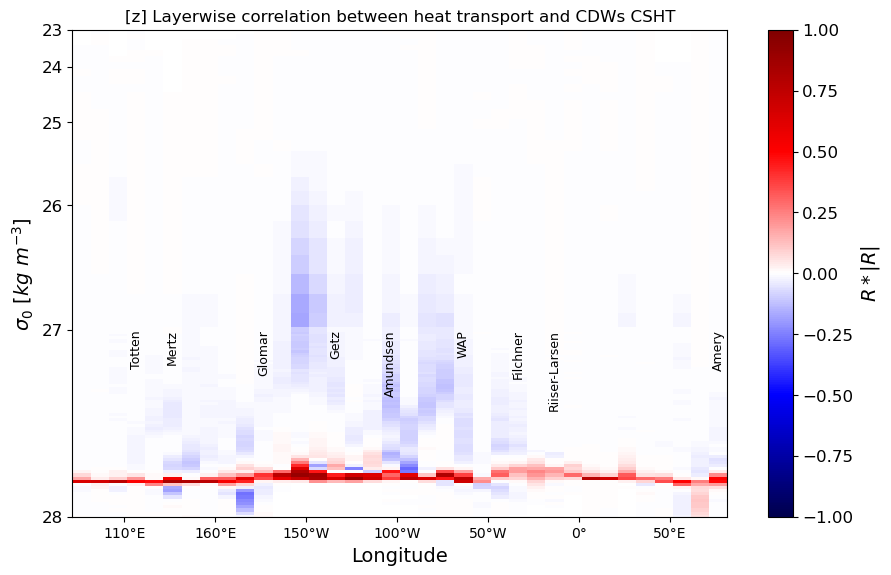

In [117]:
#conversor of vertical coordiantes
def warp(y):
    return 1.5**(y-23)  # exponential streching 1.5**(y-23)


fig = plt.figure(figsize=(22,14))
plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.15,  # the amount of width reserved for blank space between subplots
    hspace=0.3   # the amount of height reserved for white space between subplots
)

#monthly correlations
ax0 = fig.add_subplot(2,2,1)
# plt.contour(monthly_layerwise_r2s_ρ.lon_bins,warp(monthly_layerwise_r2s_ρ.potrho0),\
#                monthly_layerwise_r2s_ρ,levels=[0.5,],colors='r')
plt.pcolormesh(layerwise_CDW_r2.lon_bins,warp(layerwise_CDW_r2.potrho0),\
               layerwise_CDW_r2,cmap='seismic',vmin=-1,vmax=1)

ax0.set_yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
ax0.set_ylim(warp(28),warp(23))
cbar0 = plt.colorbar()
cbar0.ax.tick_params(labelsize=12)
cbar0.set_label(label=r'$R * |R| $', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'[z] Layerwise correlation between heat transport and CDWs CSHT')
for i in range(9):
    plt.text(annual_r2.lon_bins[longitude_inds[i]], warp(27), regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')



Text(0.5, 1.0, 'Layerwise correlation between heat transport and CDWs CSHT')

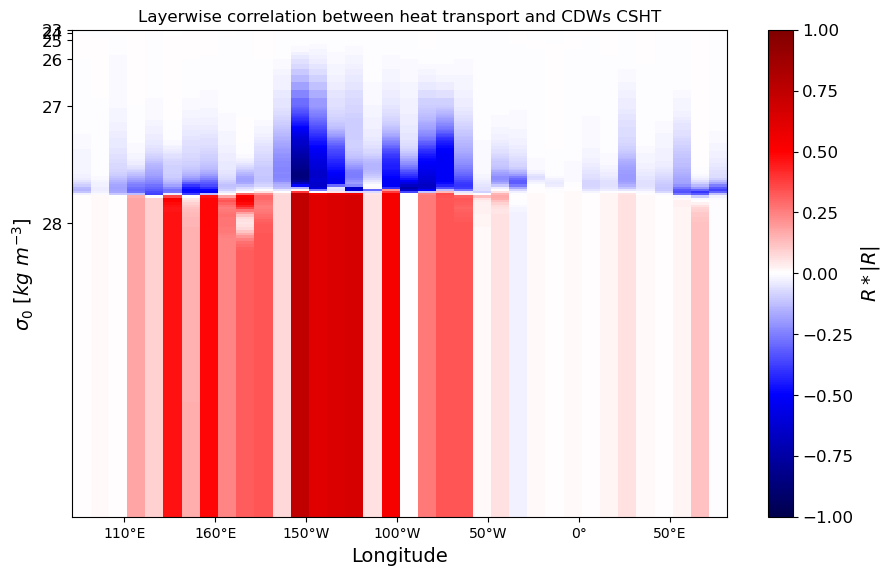

In [424]:
#conversor of vertical coordiantes
def warp(y):
    return 2.5**(y-23)  # exponential streching 1.5**(y-23)


fig = plt.figure(figsize=(22,14))
plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.15,  # the amount of width reserved for blank space between subplots
    hspace=0.3   # the amount of height reserved for white space between subplots
)

#monthly correlations
ax0 = fig.add_subplot(2,2,1)
# plt.contour(monthly_layerwise_r2s_ρ.lon_bins,warp(monthly_layerwise_r2s_ρ.potrho0),\
#                monthly_layerwise_r2s_ρ,levels=[0.5,],colors='r')
plt.pcolormesh(layerwisei_CDW_r2.lon_bins,warp(layerwisei_CDW_r2.potrho0),\
               layerwisei_CDW_r2,cmap='seismic',vmin=-1,vmax=1)

ax0.set_yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
ax0.set_ylim(warp(29),warp(23))
cbar0 = plt.colorbar()
cbar0.ax.tick_params(labelsize=12)
cbar0.set_label(label=r'$R * |R| $', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'Layerwise correlation between heat transport and CDWs CSHT')



Text(0.5, 1.0, 'Layerwise correlation between heat transport and CDWs CSHT')

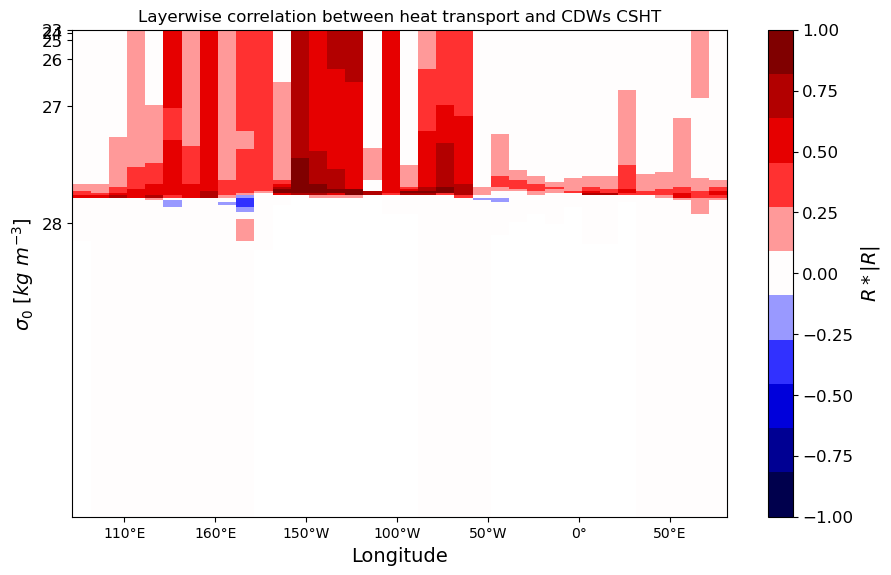

In [423]:
#conversor of vertical coordiantes
def warp(y):
    return 2.5**(y-23)  # exponential streching 1.5**(y-23)


fig = plt.figure(figsize=(22,14))
plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.15,  # the amount of width reserved for blank space between subplots
    hspace=0.3   # the amount of height reserved for white space between subplots
)

#monthly correlations
ax0 = fig.add_subplot(2,2,1)
# plt.contour(monthly_layerwise_r2s_ρ.lon_bins,warp(monthly_layerwise_r2s_ρ.potrho0),\
#                monthly_layerwise_r2s_ρ,levels=[0.5,],colors='r')
plt.pcolormesh(layerwiseu_CDW_r2.lon_bins,warp(layerwiseu_CDW_r2.potrho0),\
               layerwiseu_CDW_r2,cmap=discrete_seismic,vmin=-1,vmax=1)

ax0.set_yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
ax0.set_ylim(warp(29),warp(23))
cbar0 = plt.colorbar()
cbar0.ax.tick_params(labelsize=12)
cbar0.set_label(label=r'$R * |R| $', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'Layerwise correlation between heat transport and CDWs CSHT')


Try the method above with mass transports across the isobath

In [377]:
#Importing Christina's volume transports across isobath
Vol_transport_daily = xr.open_mfdataset('/g/data/e14/cs6673/iav_AABW/data_iav_AABW_final/vol_trans_across_contour_01deg_jra55v140_iaf_cycle3_1d_*.nc').vol_trans_across_contour
Vol_transport_daily['lon_along_contour']=CSHT_along.lon_along_contour


Integrating the mass transport in 10 degree bins

In [358]:
lon_bin=10
bin_edges = np.arange(CSHTZC_z.lon_bin_midpoints[0], CSHTZC_z.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins
newlon = np.concatenate((CSHTZC_z.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)
longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
meantime = CSHTZC_z.time.resample(time='1M').mean()

Vol_transport_daily_10deg = Vol_transport_daily.groupby_bins('lon_along_contour', bins=bin_edges).sum().rename({'lon_along_contour_bins':'lon_bins'})
Vol_transport_daily_10deg['lon_bins']=layerwise_CDW_r2.lon_bins
Vol_transport_daily_10deg = Vol_transport_daily_10deg.compute()
Vol_transport_daily_10deg_int= Vol_transport_daily_10deg[:,::-1,:].cumsum('isopycnal_bins') #cumulative sum in teh water column

Calculating the sum of negative southward and northward transports

In [394]:
Vol_transport_daily_10deg_southwards = Vol_transport_daily_10deg.where(Vol_transport_daily_10deg<0).sum('isopycnal_bins')
Vol_transport_daily_10deg_northwards = Vol_transport_daily_10deg.where(Vol_transport_daily_10deg>0).sum('isopycnal_bins')

Correlating mass transport with CSHT from CDW

In [361]:
#correlations with different water masses heat transport
MT_CDW_r = xr.corr(Vol_transport_daily_10deg ,CSHT_CDW,dim = 'time').compute()
MT_CDW_r2 = ((MT_CDW_r.where(MT_CDW_r<0)*0)-1).fillna(1) * (MT_CDW_r**2)

#integrated verions
MTi_CDW_r = xr.corr(Vol_transport_daily_10deg_int ,CSHT_CDW,dim = 'time').compute()
MTi_CDW_r2 = ((MTi_CDW_r.where(MTi_CDW_r<0)*0)-1).fillna(1) * (MTi_CDW_r**2)

In [403]:
MTS_CDW_r = xr.corr(Vol_transport_daily_10deg_southwards  ,CSHT_CDW,dim = 'time').compute()
MTS_CDW_r2 = ((MTS_CDW_r.where(MTS_CDW_r<0)*0)-1).fillna(1) * (MTS_CDW_r**2)

MTN_CDW_r = xr.corr(Vol_transport_daily_10deg_northwards,CSHT_CDW,dim = 'time').compute()
MTN_CDW_r2 = ((MTN_CDW_r.where(MTN_CDW_r<0)*0)-1).fillna(1) * (MTN_CDW_r**2)

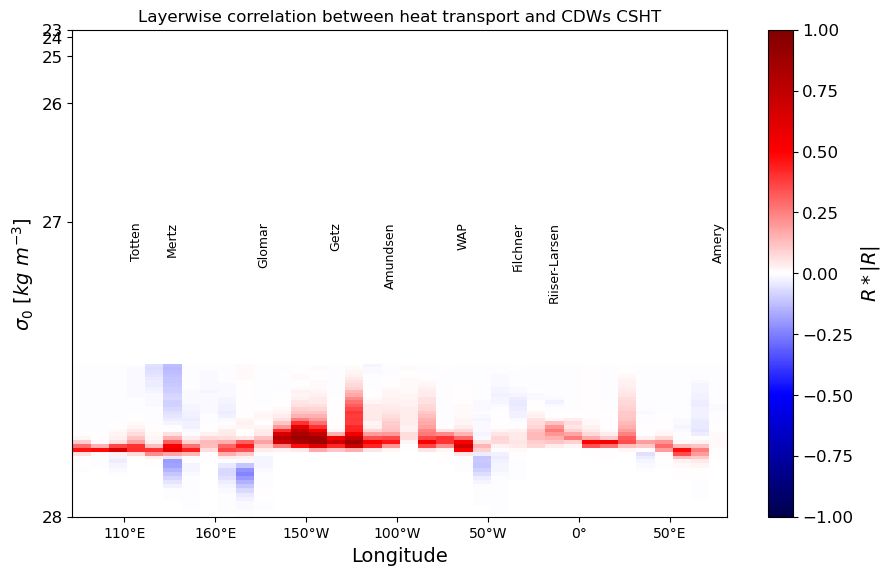

In [409]:
#conversor of vertical coordiantes
def warp(y):
    return 2.5**(y-23)  # exponential streching 1.5**(y-23)


fig = plt.figure(figsize=(22,14))
plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.15,  # the amount of width reserved for blank space between subplots
    hspace=0.3   # the amount of height reserved for white space between subplots
)

#monthly correlations
ax0 = fig.add_subplot(2,2,1)
# plt.contour(monthly_layerwise_r2s_ρ.lon_bins,warp(monthly_layerwise_r2s_ρ.potrho0),\
#                monthly_layerwise_r2s_ρ,levels=[0.5,],colors='r')
plt.pcolormesh(MT_CDW_r2.lon_bins,warp(MT_CDW_r2.isopycnal_bins),\
               MT_CDW_r2,cmap='seismic',vmin=-1,vmax=1)

ax0.set_yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
ax0.set_ylim(warp(28),warp(23))
cbar0 = plt.colorbar()
cbar0.ax.tick_params(labelsize=12)
cbar0.set_label(label=r'$R * |R| $', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'Layerwise correlation between heat transport and CDWs CSHT')
for i in range(9):
    plt.text(annual_r2.lon_bins[longitude_inds[i]], warp(27), regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')



Text(0.5, 1.0, 'Layerwise correlation between heat transport and CDWs CSHT')

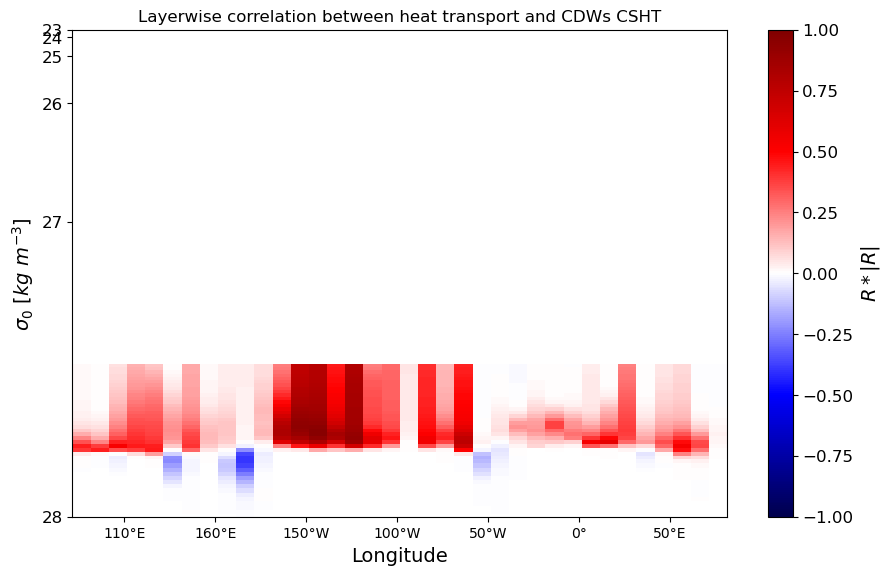

In [364]:
#conversor of vertical coordiantes
def warp(y):
    return 2.5**(y-23)  # exponential streching 1.5**(y-23)


fig = plt.figure(figsize=(22,14))
plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.15,  # the amount of width reserved for blank space between subplots
    hspace=0.3   # the amount of height reserved for white space between subplots
)

#monthly correlations
ax0 = fig.add_subplot(2,2,1)
# plt.contour(monthly_layerwise_r2s_ρ.lon_bins,warp(monthly_layerwise_r2s_ρ.potrho0),\
#                monthly_layerwise_r2s_ρ,levels=[0.5,],colors='r')
plt.pcolormesh(MTi_CDW_r2.lon_bins,warp(MTi_CDW_r2.isopycnal_bins),\
               MTi_CDW_r2,cmap='seismic',vmin=-1,vmax=1)

ax0.set_yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
ax0.set_ylim(warp(28),warp(23))
cbar0 = plt.colorbar()
cbar0.ax.tick_params(labelsize=12)
cbar0.set_label(label=r'$R * |R| $', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'Layerwise correlation between heat transport and CDWs CSHT')




## Detrended heat transports in sigma bins

Considering the negative correlations we have found so in different places in the water column, it might be worth to do a similar analysis with detrended data and using different timescales

In [428]:
CSHT_along_10deg.load()
print('loaded CSHT in 10 degree bins')

loaded CSHT in 10 degree bins


In [429]:
CSHT_sigma_10deg_detrended = linear_detrend(CSHT_along_10deg.CSHT_ZC_lon_binned)

In [433]:
CSHT_sigma_10deg_detrended_annual = CSHT_sigma_10deg_detrended.rolling(time=365,min_periods=1,center=True).mean()
CSHT_sigma_10deg_detrended_seasonal = (CSHT_sigma_10deg_detrended - CSHT_sigma_10deg_detrended_annual).rolling(time=30,min_periods=1,center=True).mean()
# #DAily timeseries
CSHT_sigma_10deg_detrended_daily = (CSHT_sigma_10deg_detrended - CSHT_sigma_10deg_detrended_annual - CSHT_sigma_10deg_detrended_seasonal)

In [439]:
#correlations with different water masses heat transport
HT_annual_CDW_r = xr.corr(CSHT_sigma_10deg_detrended_annual ,CSHT_CDW_detrended_annual,dim = 'time').compute()
HT_annual_CDW_r2 = ((HT_annual_CDW_r.where(HT_annual_CDW_r<0)*0)-1).fillna(1) * (HT_annual_CDW_r**2)

Text(0.5, 1.0, 'Layerwise interannual correlation between heat transport and CDWs CSHT')

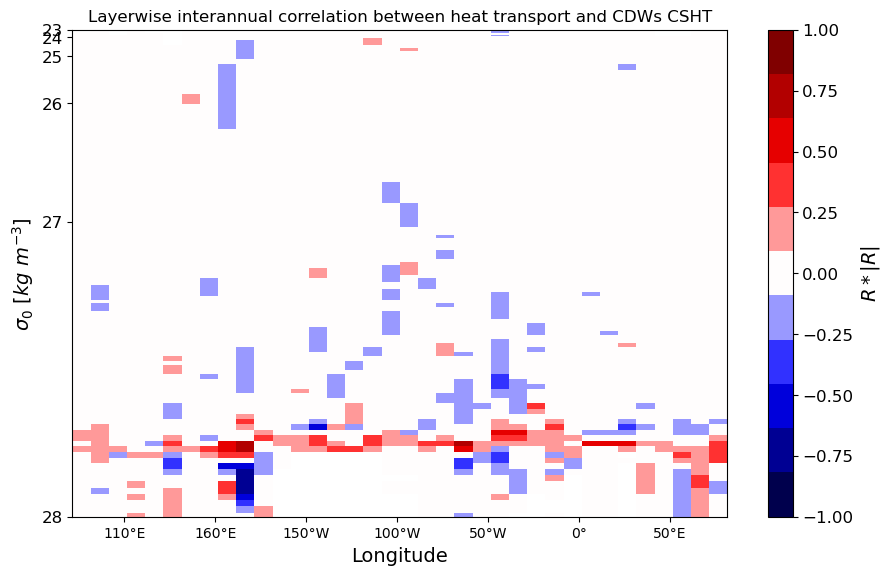

In [442]:
#conversor of vertical coordiantes
def warp(y):
    return 2.5**(y-23)  # exponential streching 1.5**(y-23)


fig = plt.figure(figsize=(22,14))
plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.15,  # the amount of width reserved for blank space between subplots
    hspace=0.3   # the amount of height reserved for white space between subplots
)

#monthly correlations
ax0 = fig.add_subplot(2,2,1)
# plt.contour(monthly_layerwise_r2s_ρ.lon_bins,warp(monthly_layerwise_r2s_ρ.potrho0),\
#                monthly_layerwise_r2s_ρ,levels=[0.5,],colors='r')
plt.pcolormesh(HT_annual_CDW_r2 .lon_bins,warp(HT_annual_CDW_r2 .potrho0),\
               HT_annual_CDW_r2 ,cmap=discrete_seismic,vmin=-1,vmax=1)

ax0.set_yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
ax0.set_ylim(warp(28),warp(23))
cbar0 = plt.colorbar()
cbar0.ax.tick_params(labelsize=12)
cbar0.set_label(label=r'$R * |R| $', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'Layerwise interannual correlation between heat transport and CDWs CSHT')



In [443]:
#correlations with different water masses heat transport
HT_seasonal_CDW_r = xr.corr(CSHT_sigma_10deg_detrended_seasonal ,CSHT_CDW_detrended_seasonal,dim = 'time').compute()
HT_seasonal_CDW_r2 = ((HT_seasonal_CDW_r.where(HT_seasonal_CDW_r<0)*0)-1).fillna(1) * (HT_seasonal_CDW_r**2)

Text(0.5, 1.0, 'Layerwise seasonal correlation between heat transport and CDWs CSHT')

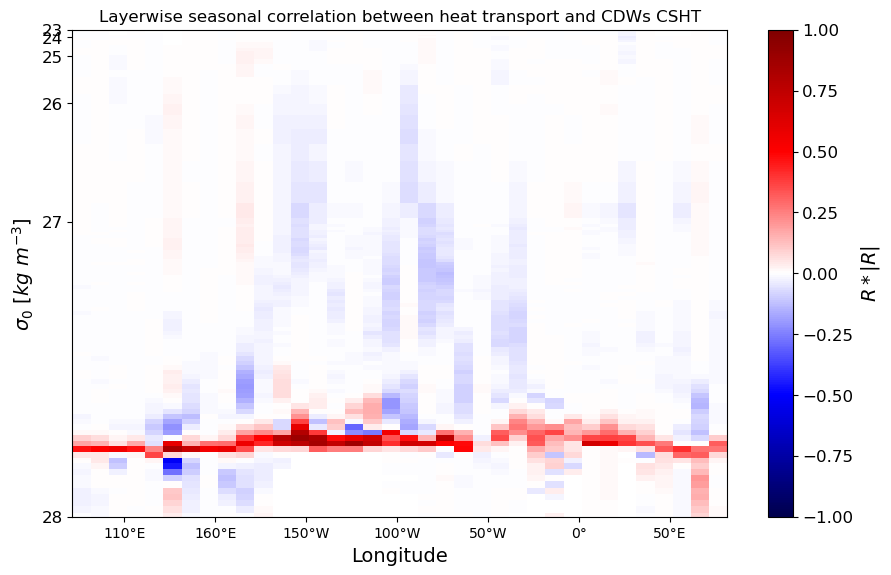

In [445]:
#conversor of vertical coordiantes
def warp(y):
    return 2.5**(y-23)  # exponential streching 1.5**(y-23)


fig = plt.figure(figsize=(22,14))
plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.15,  # the amount of width reserved for blank space between subplots
    hspace=0.3   # the amount of height reserved for white space between subplots
)

#monthly correlations
ax0 = fig.add_subplot(2,2,1)
# plt.contour(monthly_layerwise_r2s_ρ.lon_bins,warp(monthly_layerwise_r2s_ρ.potrho0),\
#                monthly_layerwise_r2s_ρ,levels=[0.5,],colors='r')
plt.pcolormesh(HT_seasonal_CDW_r2 .lon_bins,warp(HT_seasonal_CDW_r2.potrho0),\
               HT_seasonal_CDW_r2 ,cmap='seismic',vmin=-1,vmax=1)

ax0.set_yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
ax0.set_ylim(warp(28),warp(23))
cbar0 = plt.colorbar()
cbar0.ax.tick_params(labelsize=12)
cbar0.set_label(label=r'$R * |R| $', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'Layerwise seasonal correlation between heat transport and CDWs CSHT')

In [446]:
#correlations with different water masses heat transport
HT_daily_CDW_r = xr.corr(CSHT_sigma_10deg_detrended_daily ,CSHT_CDW_detrended_daily,dim = 'time').compute()
HT_daily_CDW_r2 = ((HT_daily_CDW_r.where(HT_daily_CDW_r<0)*0)-1).fillna(1) * (HT_daily_CDW_r**2)

Text(0.5, 1.0, 'Layerwise daily correlation between heat transport and CDWs CSHT')

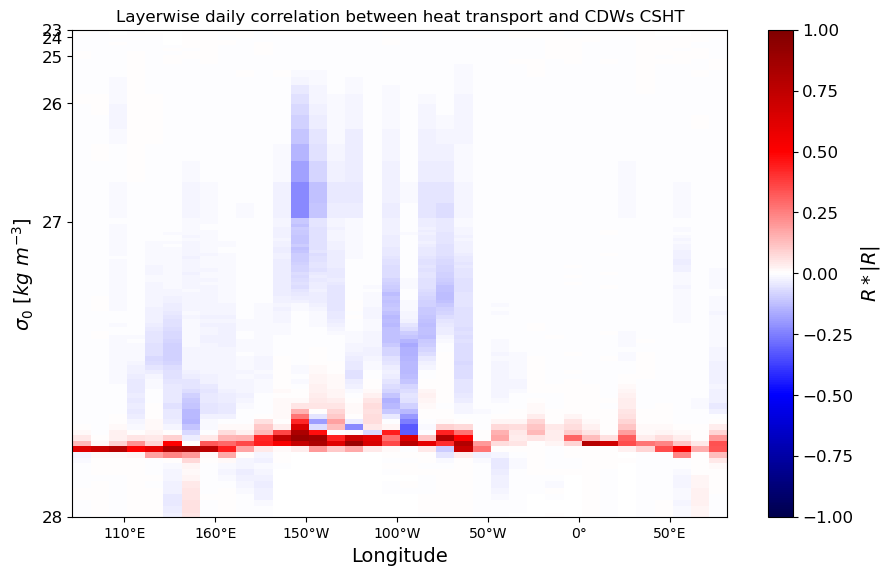

In [447]:
#conversor of vertical coordiantes
def warp(y):
    return 2.5**(y-23)  # exponential streching 1.5**(y-23)


fig = plt.figure(figsize=(22,14))
plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.15,  # the amount of width reserved for blank space between subplots
    hspace=0.3   # the amount of height reserved for white space between subplots
)

#monthly correlations
ax0 = fig.add_subplot(2,2,1)
# plt.contour(monthly_layerwise_r2s_ρ.lon_bins,warp(monthly_layerwise_r2s_ρ.potrho0),\
#                monthly_layerwise_r2s_ρ,levels=[0.5,],colors='r')
plt.pcolormesh(HT_daily_CDW_r2 .lon_bins,warp(HT_daily_CDW_r2.potrho0),\
               HT_daily_CDW_r2 ,cmap='seismic',vmin=-1,vmax=1)

ax0.set_yticks(ticks=warp(np.array([21,22,23,24,25,26,27,28])), labels=[21,22,23,24,25,26,27,28],fontsize=12)
ax0.set_ylim(warp(28),warp(23))
cbar0 = plt.colorbar()
cbar0.ax.tick_params(labelsize=12)
cbar0.set_label(label=r'$R * |R| $', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'Layerwise daily correlation between heat transport and CDWs CSHT')